In [1]:
# import necessary modules
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.vgg16 import VGG16
# from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
import cv2
import pdb

Using TensorFlow backend.


In [26]:
from keras.applications import VGG16

from keras.models import Sequential
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

import numpy as np
import os

# Data inputs

# Model inputs
batch_size = 50
epochs = 50
top_model_weights_path = 'my_model'

image_shape = (224, 224) # VGG16

# train_data_dir = '/Users/rmillin/Documents/Insight/animal-tracks/mvpapp/webapp/static/images/train'
# test_data_dir = '/Users/rmillin/Documents/Insight/animal-tracks/mvpapp/webapp/static/images/test'
train_data_dir = '/Users/rmillin/Documents/Insight/animal-tracks/multiclass/train_grayscale'
test_data_dir = '/Users/rmillin/Documents/Insight/animal-tracks/multiclass/test_grayscale'


def save_bottleneck_features(image_shape, batch_size, test_data_dir, train_data_dir):
    ''' 
    Saves bottleneck features for testing and training.
    '''
    print('\n Saving Bottleneck Features...')


    model = VGG16(weights="imagenet", include_top = False)

#     datagen = ImageDataGenerator(
#         rescale=1./255,
#         rotation_range = 10,
#         width_shift_range = 0.2,
#         height_shift_range = 0.2,
#         shear_range = 0,
#         zoom_range = 0.2,
#         fill_mode = 'nearest'
#         )
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 0,
        width_shift_range = 0,
        height_shift_range = 0,
        shear_range = 0,
        zoom_range = 0,
        fill_mode = 'nearest'
        )

    train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size = image_shape,
        batch_size = batch_size,
        class_mode = None,
        shuffle = False,
        save_to_dir='train_images_aug_gray_all', 
        save_prefix='aug'  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
        )

    if not(os.path.isfile('gray_all_bottleneck_features_train.npy')):
        train_data = model.predict_generator(train_generator, verbose=1)
        np.save(open('gray_all_bottleneck_features_train.npy','wb'), train_data)
    else:
        train_data = np.load('gray_all_bottleneck_features_train.npy')
        
    test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size = image_shape,
        batch_size = batch_size,
        class_mode = None,
        shuffle = False,
        save_to_dir='test_images_aug_gray_all', 
        save_prefix='aug'  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
        )
            
    if not(os.path.isfile('gray_all_bottleneck_features_test.npy')):
        test_data = model.predict_generator(test_generator, verbose=1)
        np.save(open('gray_all_bottleneck_features_test.npy','wb'), test_data)
    else:
        test_data = np.load('gray_all_bottleneck_features_test.npy')
        
    # with a Sequential model
    layer_name = 'block3_pool'
    intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

    train_activations = intermediate_layer_model.predict_generator(train_generator)
    test_activations = intermediate_layer_model.predict_generator(test_generator)

    
    train_y = to_categorical(train_generator.classes)
    test_y = to_categorical(test_generator.classes)
    train_labels = train_generator.class_indices
    np.save(open('train_y.npy','wb'), train_y)
    np.save(open('test_y.npy','wb'), test_y)
    np.save(open('train_labels.npy','wb'), train_labels)
        
    return train_data, test_data, train_y, train_labels, test_y, train_activations, test_activations

def train_top_model(train_data, train_y, test_data, test_y, n_classes, top_model_weights_path):
    ''' 
    Train top layer with bottleneck features as input
    '''

    print('\n Training the FC Layers...')
   
    model = Sequential()
    model.add(Flatten(input_shape = train_data.shape[1:]))
    model.add(Dense(2056, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1028, activation = 'relu'))
    model.add(Dense(n_classes, activation = 'softmax'))

    opt = optimizers.SGD(lr = 1.0e-4, momentum=0.9)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

    checkpointer = ModelCheckpoint(filepath='model.best.hdf5', verbose=1, save_best_only=False)
   
    model.fit(train_data, train_y,
             epochs=epochs,
             batch_size=batch_size,
             validation_data = [test_data, test_y],
             callbacks = [checkpointer])

    model.save_weights(top_model_weights_path)

    return model  

if (not os.path.isfile('gray_all_bottleneck_features_train.npy')) or (not os.path.isfile('gray_all_bottleneck_features_test.npy')):
    train_data, test_data, train_y, train_labels, test_y, train_activations, test_activations = \
        save_bottleneck_features(image_shape, \
        batch_size, test_data_dir, train_data_dir)
else:
    train_data = np.load('gray_all_bottleneck_features_train.npy')
    test_data = np.load('gray_all_bottleneck_features_test.npy')
    train_y = np.load('train_y.npy')
    test_y = np.load('test_y.npy') 
    train_labels = np.load('train_labels.npy')
    
print(train_data.shape)
print(test_data.shape)



 Saving Bottleneck Features...
Found 860 images belonging to 5 classes.
18/18 [==============================] - 696s 39s/step
Found 160 images belonging to 5 classes.
4/4 [==============================] - 145s 36s/step
(860, 7, 7, 512)
(160, 7, 7, 512)


In [52]:
train_data = np.load('gray_all_bottleneck_features_train.npy')
# the features were saved in order, so recreating the labels is easy
train_labels = np.array([0] * int(train_data.shape[0]/2) + [1] * int(train_data.shape[0]/2))
# train_labels = np.array([0] * 69 + [1] * 70
# train_labels = np.load('train_y.npy')

validation_data = np.load('gray_all_bottleneck_features_test.npy')
validation_labels = np.array([0] * int(test_data.shape[0]/2) + [1] * int(test_data.shape[0]/2))
# validation_labels = np.load('test_y.npy')

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=100,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')

Train on 354 samples, validate on 64 samples
Epoch 1/100
354/354 [==============================] - 2s 5ms/step - loss: 6.8472 - acc: 0.5169 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 7/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 8/100
354/354 [===

Epoch 62/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 63/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 64/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 65/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 66/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 67/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 68/100
354/354 [==============================] - 1s 3ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 69/100
354/354 [==============================] - 1s 3ms

In [209]:
train_activations.shape

(328, 28, 28, 256)

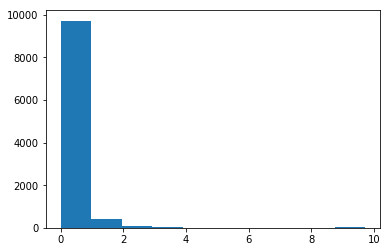

In [112]:
plt.figure()
plt.hist(test_data.flatten())
plt.show()

In [27]:
train_data = np.load('gray_all_bottleneck_features_train.npy')
train_data = np.reshape(train_data,(train_data.shape[0], 512*7*7))
# train_data = np.reshape(train_activations,(train_activations.shape[0], 28*28*256))
# the features were saved in order, so recreating the labels is easy
# train_labels = np.load('train_y.npy')
# train_labels = train_labels[:,0]
# train_labels = np.array([0] * int(train_data.shape[0]/2) + [1] * int(train_data.shape[0]/2))
train_labels = np.array([0] * int(train_data.shape[0]/5) + [1] * int(train_data.shape[0]/5) + [2] * int(train_data.shape[0]/5) + [3] * int(train_data.shape[0]/5) + [4] * int(train_data.shape[0]/5))
# train_labels = np.array([0] * 276 + [1] * 280)

test_data = np.load('gray_all_bottleneck_features_test.npy')
test_data = np.reshape(test_data,(test_data.shape[0], 512*7*7))
# test_labels = np.load('test_y.npy')
# test_labels = test_labels[:,0]
# test_data = np.reshape(test_activations,(test_activations.shape[0], 28*28*256))
# test_labels = np.array([0] * int(test_data.shape[0]/2) + [1] * int(test_data.shape[0]/2))
test_labels = np.array([0] * int(test_data.shape[0]/5) + [1] * int(test_data.shape[0]/5) + [2] * int(test_data.shape[0]/5) + [3] * int(test_data.shape[0]/5) + [4] * int(test_data.shape[0]/5))


In [28]:
print(np.sum(train_labels))
print(len(train_labels))
print(np.sum(test_labels))
print(len(test_labels))

test_labels

1720
860
320
160


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4])

In [29]:
# logistic regression classifier on features

import os
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing

# train_data = train_activations
# test_data = test_activations

s_scaler = preprocessing.StandardScaler()
train_data = s_scaler.fit_transform(train_data)
test_data = s_scaler.transform(test_data)


clf = LogisticRegression(penalty='l1',C=1).fit(train_data, train_labels)
pred = clf.predict(test_data)

print(pred)
np.save(open('pred_nn_raw.npy','wb'), pred)
np.save(open('act_nn_raw.npy','wb'), test_labels)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(train_data, train_labels)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(test_data, test_labels)))




# clf = SVC(C=0.00001,kernel='linear').fit(train_data, train_labels)
pred = clf.predict(test_data)

# print('Accuracy of SVM classifier on training set: {:.2f}'
#      .format(clf.score(train_data, train_labels)))
# print('Accuracy of SVM classifier on test set: {:.2f}'
#      .format(clf.score(test_data, test_labels)))

# train_acc_nn = []
# test_acc_nn = []
# param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
# # param_range = [10**(-20), 10**(-15), 10**(-10), 0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001]
# for this_C in param_range:
#     clf = LogisticRegression(penalty='l1', C=this_C).fit(train_data, train_labels)
# #     clf = SVC(C=this_C).fit(train_data, train_labels)
#     train_acc_nn = np.append(train_acc_nn,clf.score(train_data,train_labels))
#     test_acc_nn = np.append(test_acc_nn, clf.score(test_data,test_labels))


# plt.figure()

# plt.title('Validation Curve with CNN Features')
# plt.xlabel('C')
# plt.ylabel('Score')
# plt.ylim(0.0, 1.1)
# lw = 2

# plt.semilogx(param_range, train_acc_nn, label='Training score')

# plt.semilogx(param_range, test_acc_nn, label='Testing score')

# #plt.show()    
# plt.savefig('NN_validation.png')    
    
    
#import pdb    



/Applications/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/preprocessing/data.py:653: RuntimeWarning: invalid value encountered in sqrt
  self.scale_ = _handle_zeros_in_scale(np.sqrt(self.var_))


[4 2 2 2 0 2 0 0 3 0 4 0 0 4 2 1 2 2 2 1 4 4 0 3 0 0 0 0 2 2 2 2 0 1 1 1 3
 1 2 1 4 4 0 1 0 1 0 4 1 1 4 1 3 1 1 4 4 1 1 1 1 3 4 4 2 1 4 1 2 2 4 2 2 2
 0 0 3 3 1 1 1 1 1 1 1 2 2 2 3 4 3 2 0 4 4 4 4 2 2 2 1 1 3 1 3 2 0 0 2 3 3
 3 2 2 2 2 3 3 3 3 3 3 3 0 3 4 3 3 1 2 0 1 4 4 4 1 2 4 4 1 2 4 4 4 3 0 3 3
 4 0 2 4 1 1 3 4 4 1 4 4]
Accuracy of Logistic regression classifier on training set: 1.00
Accuracy of Logistic regression classifier on test set: 0.41


In [ ]:
plt.figure()

plt.title('Validation Curve with CNN Features')
plt.xlabel('C')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_acc_nn, label='Training score')

plt.semilogx(param_range, test_acc_nn, label='Testing score')

#plt.show()    
plt.savefig('NN_validation.png')    


In [35]:
import pdb
import cv2


animals = ['bear','canine','feline','hooved','others']
    
# also get accuracy for RGB values
training_data=np.empty([0, 224**2])
testing_data=np.empty([0, 224**2])
for animal in animals:
    for name in os.listdir(os.path.join(train_data_dir,animal)):
        try:
            img = cv2.imread(os.path.join(train_data_dir,animal,name))
            training_data = np.append(training_data,np.matrix(img[:,:,0].flatten()),axis=0)
        except:
#            pdb.set_trace()
            print(name)

    for name in os.listdir(os.path.join(test_data_dir,animal)):
        try:
            img = cv2.imread(os.path.join(test_data_dir,animal,name))
            testing_data = np.append(testing_data,np.matrix(img[:,:,0].flatten()),axis=0)
        except:
    #        pdb.set_trace()
            print(name)


min_max_scaler = preprocessing.MinMaxScaler()
training_data = min_max_scaler.fit_transform(training_data)
testing_data = min_max_scaler.transform(testing_data)

# train_acc_rgb = []
# test_acc_rgb = []
# for this_C in param_range:
#     clf = LogisticRegression(penalty='l1', C=this_C).fit(training_data, train_labels)
# #     clf = SVC(C=this_C).fit(training_data, training_labels)
#     train_acc_rgb = np.append(train_acc_rgb,clf.score(training_data,training_labels))
#     test_acc_rgb = np.append(test_acc_rgb,clf.score(testing_data,test_labels))


# plt.figure()

# plt.title('Validation Curve with RGB Values')
# plt.xlabel('C')
# plt.ylabel('Score')
# plt.ylim(0.0, 1.1)
# lw = 2

# plt.semilogx(param_range, train_acc_rgb, label='Training score')

# plt.semilogx(param_range, test_acc_rgb, label='Testing score')

# #plt.show()    
# plt.savefig('RGB_validation.png')  

# print(np.sum(training_labels))
# print(len(training_labels))
# print(np.sum(testing_labels))
# print(len(testing_labels))

# np.save(open('pred_intens_filt.npy','wb'), pred)
# np.save(open('act_intens_filt.npy','wb'), test_labels)


.DS_Store
.DS_Store
.DS_Store
.DS_Store
.DS_Store
.DS_Store
.DS_Store
.DS_Store
.DS_Store
.DS_Store


In [36]:

print(training_data.shape)
clf = LogisticRegression(penalty='l1',C=1).fit(training_data, train_labels)
pred = clf.predict(testing_data)

print(pred)
np.save(open('pred_intens_raw.npy','wb'), pred)
np.save(open('act_intens_raw.npy','wb'), test_labels)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(training_data, train_labels)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(testing_data, test_labels)))


(860, 50176)
[0 0 0 0 1 0 1 1 3 3 3 3 1 1 1 1 1 1 1 1 3 3 3 3 2 2 2 2 1 1 1 1 2 2 2 2 3
 1 1 1 3 3 3 3 1 1 1 1 3 3 3 3 2 2 2 2 1 2 2 2 1 1 1 1 2 2 2 2 4 4 4 4 0 0
 0 0 1 4 1 1 4 4 4 4 1 1 1 1 4 4 4 4 4 4 4 4 3 3 3 3 1 1 1 1 0 0 4 4 1 1 1
 1 2 2 3 2 3 3 3 3 2 4 2 2 2 2 2 2 3 1 3 1 0 3 0 1 0 0 0 0 4 4 4 4 4 4 4 4
 4 4 4 4 3 1 3 1 3 3 3 3]
Accuracy of Logistic regression classifier on training set: 0.95
Accuracy of Logistic regression classifier on test set: 0.26


In [21]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 50, 50

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '/Users/rmillin/Documents/Insight/animal-tracks/mvpapp/webapp/static/images/train'
validation_data_dir = '/Users/rmillin/Documents/Insight/animal-tracks/mvpapp/webapp/static/images/test'
nb_train_samples = 2000
nb_validation_samples = 800
batch_size = 16


def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet', input_shape=(50,50,3))

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_train.npy',
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)

In [22]:
save_bottleneck_features()

Found 106 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [36]:
train_labels.shape

(92,)

In [68]:
# get output from layer layer_name = 'my_layer'
intermediate_layer_model = Model(inputs=base_model.input,
                                 outputs=base_model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(data)

NameError: name 'layer_name' is not defined

In [46]:
len([name for name in os.listdir('/Users/rmillin/Documents/Insight/animal-tracks/images/first_test/test/dog')])

37

In [27]:
train_data.shape

(44, 512)

In [53]:
50*50*3

7500

In [65]:
img

In [74]:
os.path.join(train_dir,name)

'/Users/rmillin/Documents/Insight/web-app/flaskexample/static/images/train/cougar/.DS_Store'

In [29]:
#     preprocessing_function=preprocess_input,

train_datagen =  image.ImageDataGenerator(
    rotation_range=90,
    shear_range=0,
    zoom_range=0,
    vertical_flip=True,
    horizontal_flip=True
)
#     preprocessing_function=preprocess_input,

test_datagen = image.ImageDataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    vertical_flip=False,
    horizontal_flip=False
)
#pdb.set_trace()
batch_size_train = 16
batch_size_test = 1
# os.makedirs('train_images_aug')
train_generator = train_datagen.flow_from_directory(
  '/Users/rmillin/Documents/Insight/animal-tracks/mvpapp/webapp/static/images/train',
  target_size=(50,50),
  batch_size=batch_size_train,
  class_mode=None,  # this means our generator will only yield batches of data, no labels
  shuffle=False,
  save_to_dir='train_images_aug', 
  save_prefix='aug')  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs
for k in train_generator:
    print('train')
    break
# os.makedirs('test_images_aug')
test_generator = test_datagen.flow_from_directory(
  '/Users/rmillin/Documents/Insight/animal-tracks/mvpapp/webapp/static/images/test',
  target_size=(50,50),
  batch_size=batch_size_test,
  class_mode=None,  # this means our generator will only yield batches of data, no labels
  shuffle=False,
  save_to_dir='test_images_aug', 
  save_prefix='aug')  # our data will be in order, so all first 1000 images will be cats, then 1000 dogs


Found 44 images belonging to 2 classes.
train
Found 23 images belonging to 2 classes.


In [60]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications

# dimensions of our images.
img_width, img_height = 50, 50

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '/Users/rmillin/Documents/Insight/animal-tracks/mvpapp/webapp/static/images/train'
validation_data_dir = '/Users/rmillin/Documents/Insight/animal-tracks/mvpapp/webapp/static/images/test'
nb_train_samples = 92
nb_validation_samples = 20
batch_size = 2


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
#    model = applications.VGG16(include_top=False, weights='imagenet', pooling='max')
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        class_mode=None,
        batch_size=batch_size,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_train.npy',
            bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        class_mode=None,
        batch_size=batch_size,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)

save_bottlebeck_features()

Found 92 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [25]:
13/21

0.6190476190476191

In [30]:
# get the bottleneck features to use for classification

vgg_conv = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(50, 50,3))

bottleneck_features_train = vgg_conv.predict_generator(train_generator)
# save the output as a Numpy array
np.save('bottleneck_features_train.npy', bottleneck_features_train)

bottleneck_features_test = vgg_conv.predict_generator(test_generator)
# save the output as a Numpy array
np.save('bottleneck_features_test.npy', bottleneck_features_test)



In [26]:
# get the number of each class in train and test
import fnmatch
import os

# -1 below for DSstore file.  NEED TO CHECK AND FIX!!!!
n_dogs = 22
n_cougars = 22
train_labels = np.array([0] * n_cougars + [1] * n_dogs)

n_dogs = 8
n_cougars = 15
# n_dogs = len([name for name in os.listdir('/Users/rmillin/Documents/Insight/animal-tracks/images/first_test/test/dog')])-1
# n_cougars = len([name for name in os.listdir('/Users/rmillin/Documents/Insight/animal-tracks/images/first_test/test/cougar')])-1
test_labels = np.array([0] * n_cougars + [1] * n_dogs)


# load the data into numpy arrays
train_data = np.squeeze(np.load('bottleneck_features_train.npy'))
# the features were saved in order, so recreating the labels is easy

test_data = np.squeeze(np.load('bottleneck_features_test.npy'))


In [160]:
model = VGG16(weights="imagenet", include_top = False)
model

In [193]:
model.layers[10].name

'block3_pool'